#### **The turn of the month effect via the macro news channel**

### Data loading
DashForCash Data:
- 1.CRSP Value weighted  |(Jan, 1980 to December, 2013), Settlement period = 5 or 3|(July, 1995 to December, 2013), Settlement period = 3
- 2.S&P 500 |(Jan, 1980 to December, 2013), Settlement period = 5 or 3|(July, 1995 to December, 2013), Settlement period = 3

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import duckdb
import fastparquet

In [87]:
if os.path.exists('/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'):
    data_folder = '/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'
    os.chdir(data_folder)   
else:
    print('Please point to the right data path!')

In [88]:
# loading data
con = duckdb.connect()

query = ("""
    SELECT 
        crsp.permno,
        CAST(crsp.dlycaldt AS DATE) AS date,
        crsp.dlyprc AS price,
        crsp.dlyret AS ret,
        crsp.dlycap AS market_cap,
        crsp.dlybid AS bid,
        crsp.dlyask AS ask,
        crsp.dlyvol AS volume,
        crsp.dlyprcvol AS price_volume,
        crsp.dlyhigh AS high,
        crsp.dlylow AS low,
        dse.exchcd,
        dse.shrcd
    FROM read_parquet('data/crsp_202401.dsf_v2.parquet') crsp
    LEFT JOIN read_parquet('data/crsp_202401.dsenames.parquet') dse
        ON crsp.permno = dse.permno
        AND crsp.dlycaldt BETWEEN dse.namedt AND COALESCE(dse.nameendt, '9999-12-31')
        AND dse.namedt IS NOT NULL
    WHERE crsp.dlycaldt BETWEEN '1995-07-01' AND '2023-12-31'
""")

df = con.execute(query).fetch_df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Replicating the DashForCash Table 1, row 1

#### Using sql to calculate value weight return since it is WAY FASTER!

In [89]:
con = duckdb.connect()

vw_query = """
WITH 
month_end AS (
    SELECT 
        permno,
        LAST_DAY(LAST(date)) AS month_end_date,
        LAST(market_cap) AS lagged_mktcap
    FROM df
    WHERE market_cap IS NOT NULL
    
    GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
),
merged_data AS (
    SELECT 
        crsp.*,
        m.lagged_mktcap
    FROM df crsp
    LEFT JOIN month_end m
    ON crsp.permno = m.permno
    AND m.month_end_date = LAST_DAY(crsp.date - INTERVAL 1 MONTH)
)
SELECT
    date,
    SUM(ret * lagged_mktcap) / NULLIF(SUM(lagged_mktcap), 0) AS vwret
FROM merged_data
WHERE lagged_mktcap IS NOT NULL
AND exchcd IN (1, 2, 3)
AND shrcd IN (10, 11)
AND ret IS NOT NULL
GROUP BY date
ORDER BY date
"""

vw_returns = con.execute(vw_query).fetch_df()
vw_returns['date'] = pd.to_datetime(vw_returns['date'])
vw_returns.rename(columns={'vwret': 'vw_ret'}, inplace=True)
vw_returns.tail()

,date,vw_ret
7149,2023-12-22,0.002232
7150,2023-12-26,0.004785
7151,2023-12-27,0.001667
7152,2023-12-28,0.000204
7153,2023-12-29,-0.003818


In [90]:
# in sample period from 1995-07-01 to 2013-12-31
vw_returns = vw_returns[vw_returns['date'] <= '2013-12-31']
vw_returns.tail()

,date,vw_ret
4633,2013-12-24,0.003318
4634,2013-12-26,0.004340
4635,2013-12-27,-0.000358
4636,2013-12-30,0.000031
4637,2013-12-31,0.004273


In [91]:
# Identify Trading Days Relative to Month End
# label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values('date')
    df['month'] = df['date'].dt.to_period('M')
    
    # Initialize trading day labels
    df['trading_day'] = np.nan 
    
    for month in df['month'].unique():
        month_data = df[df['month'] == month]
        n_days = len(month_data)
        
        for i, idx in enumerate(month_data.index):
            days_to_end = n_days - i - 1
            if days_to_end <= 8:
                df.loc[idx, 'trading_day'] = -days_to_end
             
        next_month_data = df[df['month'] == month + 1]
        for i, idx in enumerate(next_month_data.index[:8]):
            df.loc[idx, 'trading_day'] = i + 1
            
    return df

daily_vw_returns = label_trading_days(vw_returns)

In [92]:
daily_vw_returns.columns

Index(['date', 'vw_ret', 'month', 'trading_day'], dtype='object')


Period Statistics:
                mean       std  count  abnormal_ret    t_stat   p_value
period                                                                 
T+4_to_T+8 -0.000254  0.012588   1098     -0.000707 -1.859920  0.063164
T-3_to_T-1  0.001271  0.012745    663      0.000819  1.654285  0.098544
T-8_to_T-4 -0.000339  0.012489   1105     -0.000791 -2.106349  0.035399
T_0         0.000310  0.011570    221     -0.000143 -0.183223  0.854792
T_1 to_T+3  0.001262  0.012921    660      0.000810  1.610838  0.107694
other       0.001130  0.013057    891      0.000678  1.550152  0.121460


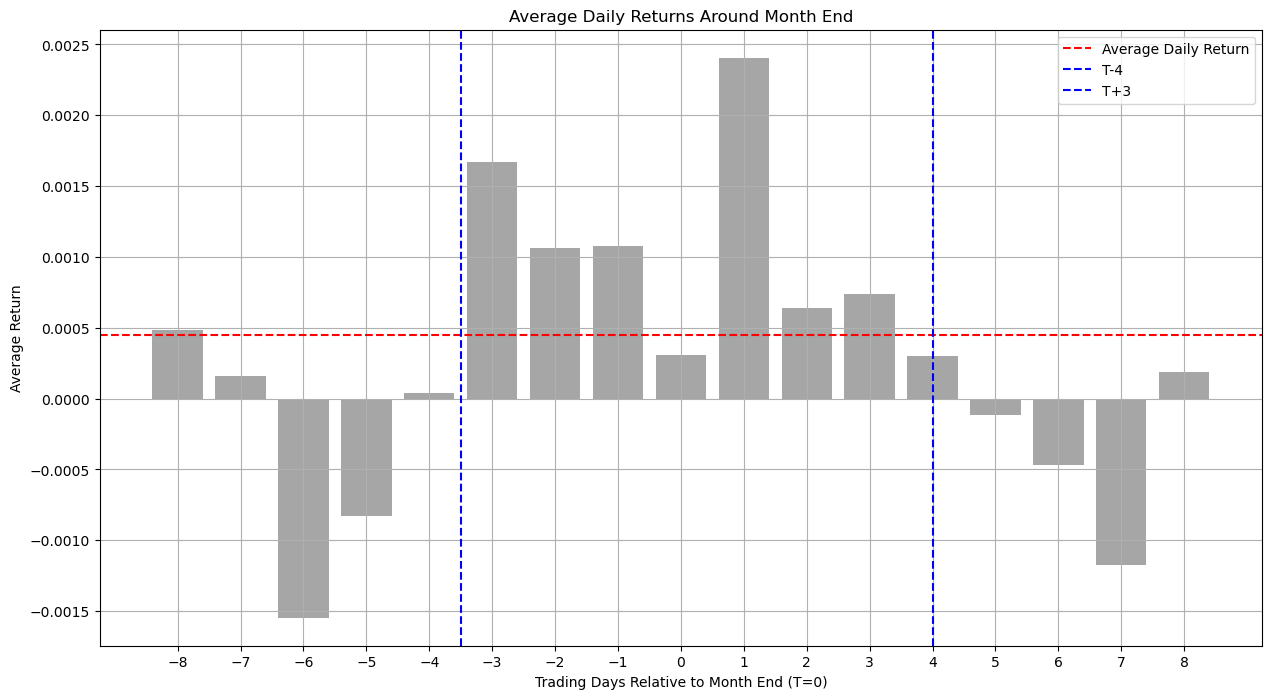

In [93]:
# get Period Returns
# Define the periods according to the paper
daily_vw_returns['period'] = 'other'
# daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-10,-9), 'period'] = 'T_10_to_T_9'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-8, -4), 'period'] = 'T-8_to_T-4'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-3, -1), 'period'] = 'T-3_to_T-1'
daily_vw_returns.loc[daily_vw_returns['trading_day'] == 0, 'period'] = 'T_0'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(1, 3), 'period'] = 'T_1 to_T+3'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(4, 8), 'period'] = 'T+4_to_T+8'
# daily_vw_returns.loc[daily_vw_returns['trading_day'].between(9, 10), 'period'] = 'T+9_to_T+10'

# get average returns by period
period_stats = daily_vw_returns.groupby('period')['vw_ret'].agg(['mean', 'std', 'count'])
avg_daily_ret = daily_vw_returns['vw_ret'].mean()

# compute abnormal returns
period_stats['abnormal_ret'] = period_stats['mean'] - avg_daily_ret
period_stats['t_stat'] = (period_stats['abnormal_ret'] * np.sqrt(period_stats['count']) / 
                         period_stats['std'])
period_stats['p_value'] = 2 * (1 - stats.t.cdf(abs(period_stats['t_stat']), 
                                              period_stats['count'] - 1))

print("\nPeriod Statistics:")
print(period_stats)

# plot the graph
plt.figure(figsize=(15, 8))
daily_means = daily_vw_returns.groupby('trading_day')['vw_ret'].mean()

# plt.plot(daily_means.index, daily_means.values, marker='o')
plt.bar(daily_means.index, daily_means.values, color='grey', alpha=0.7)
plt.axhline(y=avg_daily_ret, color='r', linestyle='--', label='Average Daily Return')
plt.axvline(x=-3.5, color='b', linestyle='--', label='T-4')
plt.axvline(x=4, color='b', linestyle='--', label='T+3')
plt.title('Average Daily Returns Around Month End')
plt.xlabel('Trading Days Relative to Month End (T=0)')
plt.ylabel('Average Return')
x_ticks = range(int(min(daily_means.index)), int(max(daily_means.index))+1)
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.show()

## Loading the macro news data

In [94]:
# loading the CPI data
cpi = pd.read_excel('data/CPI.xlsx')
cpi = cpi[cpi['Event']== 'CPI MoM'].sort_values('Date Time')
# keep only the date
cpi['Date'] = pd.to_datetime(cpi['Date Time']).dt.date
# Retain only the relevant columns and drop duplicates
cpi = cpi[['Date', 'Actual', 'Survey','Prior']].drop_duplicates()
# rename the columns
cpi = cpi.rename(columns={
    'Survey': 'Survey_Value',
    'Actual': 'Actual_Value'
})
# add the announcement type
cpi['Announcement_Type'] = 'CPI'

# loading the FOMC data
FOMC = pd.read_excel('data/FOCM.xlsx')
FOMC = FOMC[FOMC['Event']== 'FOMC Rate Decision (Upper Bound)'].sort_values('Date Time')
FOMC['Date'] = pd.to_datetime(FOMC['Date Time']).dt.date
FOMC = FOMC[['Date', 'Actual', 'Surv(A)', 'Surprise', 'Prior']].drop_duplicates()
FOMC = FOMC.rename(columns={
    'Surv(A)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
FOMC['Announcement_Type'] = 'FOMC'

# replace '--' with NaN
FOMC['Survey_Value'] = pd.to_numeric(FOMC['Survey_Value'], errors='coerce')

# forward fill the missing survey values for an unexpected FOMC
FOMC['Survey_Value'] = FOMC['Survey_Value'].fillna(FOMC['Prior'])

# get the difference
# how much the rate change from the prior meeting
FOMC['Acutal_prior_diff'] = FOMC['Actual_Value'] - FOMC['Prior']
# how much the expected rate change from the prior meeting, showing the market sentiment?
FOMC['Survey_prior_diff'] = FOMC['Survey_Value'] - FOMC['Prior']

FOMC['rate_premium'] = FOMC['Actual_Value'] - FOMC['Survey_Value']


# loading the NFP data
nfp = pd.read_excel('data/Unemployment.xlsx')
nfp = nfp[nfp['Event']== 'Change in Nonfarm Payrolls'].sort_values('Date Time')
nfp['Date'] = pd.to_datetime(nfp['Date Time']).dt.date
nfp = nfp[['Date', 'Actual', 'Surv(A)', 'Surprise', 'Prior']].drop_duplicates()
nfp = nfp.rename(columns={
    'Surv(A)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
nfp['Announcement_Type'] = 'NFP'

nfp['Survey_Value'] = pd.to_numeric(nfp['Survey_Value'], errors='coerce')
nfp['Actual_Value'] = pd.to_numeric(nfp['Actual_Value'], errors='coerce')
nfp['Prior'] = pd.to_numeric(nfp['Prior'], errors='coerce')

# difference between the expected and prior values, shows the current market prediction
nfp['nfp_diff_expected'] = nfp['Survey_Value'] - nfp['Prior']
# difference between the actual and prior values, shows the surprise
nfp['nfp_diff_actual'] = nfp['Actual_Value'] - nfp['Prior']

# difference between the actual and expected values
nfp['nfp_diff'] = nfp['Actual_Value'] - nfp['Survey_Value']

In [95]:
import statsmodels.iolib.summary2 as sm_summary

# Combine all macro announcements
macro_announcements = pd.concat([cpi, FOMC, nfp])
macro_announcements

# Create dummy variables for each announcement type
macro_announcements = pd.get_dummies(macro_announcements, 
                                    columns=['Announcement_Type'],
                                    prefix='',
                                    prefix_sep='')


# Ensure 'date' in daily_vw_returns is datetime
daily_vw_returns['date'] = pd.to_datetime(daily_vw_returns['date'])

# Ensure 'Date' in macro_announcements is datetime
macro_announcements['Date'] = pd.to_datetime(macro_announcements['Date'])

# Merge with returns data
merged_data = daily_vw_returns.merge(
    macro_announcements,
    left_on='date',
    right_on='Date',
    how='left'
)

# Fill missing announcement dummies with 0
announcement_types = ['CPI', 'FOMC','NFP']
for atype in announcement_types:
    merged_data[atype] = merged_data[atype].fillna(0)

# create turn-of-the-month dummy please
merged_data['turn_of_month'] = ((merged_data['trading_day'] >=-3) & 
                               (merged_data['trading_day'] <=3)).astype(int)


# Create dummies for each period based on trading_day
merged_data['selling_pressure'] = (merged_data['trading_day'].between(-8, -4)).astype(int)
merged_data['positive_reversal'] = (merged_data['trading_day'].between(-3, -1)).astype(int)
merged_data['month_end'] = (merged_data['trading_day'] == 0).astype(int)
merged_data['buying_pressure'] = (merged_data['trading_day'].between(1, 3)).astype(int)
merged_data['negative_reversal'] = (merged_data['trading_day'].between(4, 8)).astype(int)


# create the dummy variables for each period
period_dummies = pd.get_dummies(merged_data['period'], dtype=int)

# Merge the dummy variables with the original dataframe
merged_data = pd.concat([merged_data, period_dummies], axis=1)

# Create FOMC dummy (1 for FOMC announcement days, 0 otherwise)
merged_data['FOMC'] = merged_data['Date'].notna().astype(int)

# Convert Actual_Value and Prior to numeric values before comparison
merged_data['Actual_Value'] = pd.to_numeric(merged_data['Actual_Value'], errors='coerce')
merged_data['Prior'] = pd.to_numeric(merged_data['Prior'], errors='coerce')

# Now the comparisons will work
merged_data['Rate_Cut'] = ((merged_data['Actual_Value'] < merged_data['Prior']) & 
                          (merged_data['FOMC'] == 1)).astype(int)
merged_data['Rate_Hike'] = ((merged_data['Actual_Value'] > merged_data['Prior']) & 
                           (merged_data['FOMC'] == 1)).astype(int)



# If diff > 0, the actual rate is higher than the expected rate, bad surprise
# If diff < 0, the actual rate is lower than the expected rate, good surprise
merged_data['Good_interest'] = ((merged_data['rate_premium'] < 0)).astype(int)
merged_data['Bad_interest'] = ((merged_data['rate_premium'] > 0)).astype(int)

merged_data['Good_nfp'] = ((merged_data['nfp_diff'] < 0)).astype(int)
merged_data['Bad_nfp'] = ((merged_data['nfp_diff'] > 0)).astype(int)



# Run regression
base1 = smf.ols(
    formula='vw_ret ~ turn_of_month',
    data=merged_data
).fit()

base2 = smf.ols(
    formula='vw_ret ~ selling_pressure + positive_reversal + month_end + buying_pressure + negative_reversal',
    data=merged_data
).fit()

all_macros1 = smf.ols(
    formula='vw_ret ~ turn_of_month *(NFP + CPI + FOMC)',
    data=merged_data
).fit()

all_macros2 = smf.ols(
    formula='vw_ret ~ (selling_pressure + positive_reversal + month_end + buying_pressure + negative_reversal + FOMC + CPI + NFP)',
    data=merged_data
).fit()

rate_cut = smf.ols(
    formula='vw_ret ~ turn_of_month*Rate_Cut',
    data=merged_data
).fit()

rate_hike = smf.ols(
    formula='vw_ret ~ turn_of_month*Rate_Hike',
    data=merged_data
).fit()

good = smf.ols(
    formula='vw_ret ~ turn_of_month + Good_interest + Good_nfp',
    data=merged_data
).fit()

bad = smf.ols(
    formula='vw_ret ~ turn_of_month + Bad_interest + Bad_nfp',
    data=merged_data
).fit()

good_new2 = smf.ols(
    formula='vw_ret ~ selling_pressure + positive_reversal + month_end + buying_pressure + negative_reversal + Good_interest + Good_nfp',
    data=merged_data
).fit()

bad_news2 = smf.ols(
    formula='vw_ret ~ selling_pressure + positive_reversal + month_end + buying_pressure + negative_reversal + Bad_interest + Bad_nfp',
    data=merged_data
).fit()

# print the results on the same table
summary_table = sm_summary.summary_col([base1, all_macros1, good, bad], stars=True,
                                        model_names=['Base1', 'All Macros1','Good_news', 'Bad_news'])

summary_table2 = sm_summary.summary_col([base2, all_macros2, good_new2, bad_news2], stars=True,
                                        model_names=['Base2', 'All Macros2', 'Good_news', 'Bad_news'])

print(summary_table)


                           Base1   All Macros1 Good_news Bad_news
-----------------------------------------------------------------
Intercept                 0.0002   -0.0000     0.0001    0.0001  
                          (0.0002) (0.0002)    (0.0002)  (0.0002)
turn_of_month             0.0010** 0.0010**    0.0010**  0.0010**
                          (0.0004) (0.0004)    (0.0004)  (0.0004)
NFP[T.True]                        -0.0020                       
                                   (0.0018)                      
CPI[T.True]                        -0.0044***                    
                                   (0.0016)                      
turn_of_month:NFP[T.True]          -0.0020                       
                                   (0.0029)                      
turn_of_month:CPI[T.True]          -0.0029                       
                                   (0.0077)                      
FOMC                               0.0040***                     
         

In [96]:
print(summary_table2)


                    Base2    All Macros2 Good_news   Bad_news 
--------------------------------------------------------------
Intercept         0.0013***  0.0014***   0.0012***  0.0013*** 
                  (0.0004)   (0.0005)    (0.0004)   (0.0004)  
selling_pressure  -0.0016*** -0.0018***  -0.0016*** -0.0016***
                  (0.0006)   (0.0006)    (0.0006)   (0.0006)  
positive_reversal -0.0000    -0.0003     -0.0000    -0.0000   
                  (0.0007)   (0.0007)    (0.0006)   (0.0006)  
month_end         -0.0010    -0.0013     -0.0010    -0.0010   
                  (0.0010)   (0.0010)    (0.0010)   (0.0010)  
buying_pressure   -0.0000    -0.0004     -0.0000    -0.0001   
                  (0.0007)   (0.0007)    (0.0007)   (0.0007)  
negative_reversal -0.0015*** -0.0019***  -0.0016*** -0.0017***
                  (0.0006)   (0.0006)    (0.0006)   (0.0006)  
CPI[T.True]                  -0.0053***                       
                             (0.0014)                 

In [97]:
def plot_macro_by_type(ret):
    """
    Plot the monthly pattern of returns, comparing days with and without each macro announcement type.
    
    Parameters:
        ret (DataFrame): DataFrame with daily returns (vw_ret), a 'trading_day' column, 
                           and dummy columns for each macro announcement type (CPI, FOMC, Unemployment).
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # List of macro announcement types (these columns should be 1 if the event occurred, 0 otherwise)
    macro_types = ['CPI', 'FOMC', 'NFP']

    # Create a subplot grid: 1 row x number of macro types columns
    fig, axes = plt.subplots(1, len(macro_types), figsize=(18, 6))

    # If only one macro type is present, force axes to be iterable
    if len(macro_types) == 1:
        axes = [axes]

    # Loop over the macro types, and for each, filter days with and without the announcement.
    for idx, mtype in enumerate(macro_types):
        ax = axes[idx]
        
        # Filter data for days with and without the current macro announcement type
        with_macro = ret[ret[mtype] == 1]
        without_macro = ret[ret[mtype] == 0]

        # Calculate average returns by trading day for both groups
        with_macro_means = with_macro.groupby('trading_day')['vw_ret'].mean()
        without_macro_means = without_macro.groupby('trading_day')['vw_ret'].mean()

        # Plot the lines comparing the two groups
        ax.plot(without_macro_means.index, without_macro_means.values, 
                marker='o', label=f'Days without {mtype} News', color='blue', alpha=0.7)
        ax.plot(with_macro_means.index, with_macro_means.values, 
                marker='s', label=f'Days with {mtype} News', color='red', alpha=0.7)

        # Add reference lines
        ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=-4, color='green', linestyle='--', label='T-4', alpha=0.5)
        ax.axvline(x=3, color='green', linestyle='--', label='T+3', alpha=0.5)

        # Shade selected periods:
        # Selling Pressure: T-8 to T-4
        ax.axvspan(-8, -4, color='red', alpha=0.1, label='Selling Pressure')
        # Turn-of-Month (ToM) Effect: T-3 to T+3
        ax.axvspan(-3, 3, color='green', alpha=0.1, label='ToM Effect')

        # Customize each subplot
        ax.set_title(f'Turn-of-Month Returns: {mtype} Announcement vs. None')
        ax.set_xlabel('Trading Days Relative to Month End (T=0)')
        ax.set_ylabel('Average Return')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [85]:
# Define the specific periods
def categorize_period(trading_day):
    if -8 <= trading_day <= -4:
        return 'selling_pressure'
    elif -3 <= trading_day <= -1:
        return 'positive_reveral'
    elif trading_day == 0:
        return 'month_end'
    elif 1 <= trading_day <= 3:
        return 'buying_pressure'
    elif 4 <= trading_day <= 8:
        return 'negative_reversal'
    else:
        return 'Other'

# Apply the categorization
merged_data['period'] = merged_data['trading_day'].apply(categorize_period)

# drop the other period
merged_data = merged_data[merged_data['period'] != 'Other']

# Count overlaps for each announcement type
overlap_counts = {}
for atype in announcement_types:
    overlap_counts[atype] = merged_data[merged_data[atype] == 1]['period'].value_counts()

# Display the results
for atype, counts in overlap_counts.items():
    print(f"Overlap counts for {atype}:")
    print(counts)
    print("\n")

Overlap counts for CPI:
period
selling_pressure     49
positive_reveral      3
negative_reversal     2
Name: count, dtype: int64


Overlap counts for FOMC:
period
negative_reversal    158
selling_pressure      87
buying_pressure       87
positive_reveral      29
month_end             11
Name: count, dtype: int64


Overlap counts for NFP:
period
negative_reversal    131
buying_pressure       68
selling_pressure       1
Name: count, dtype: int64




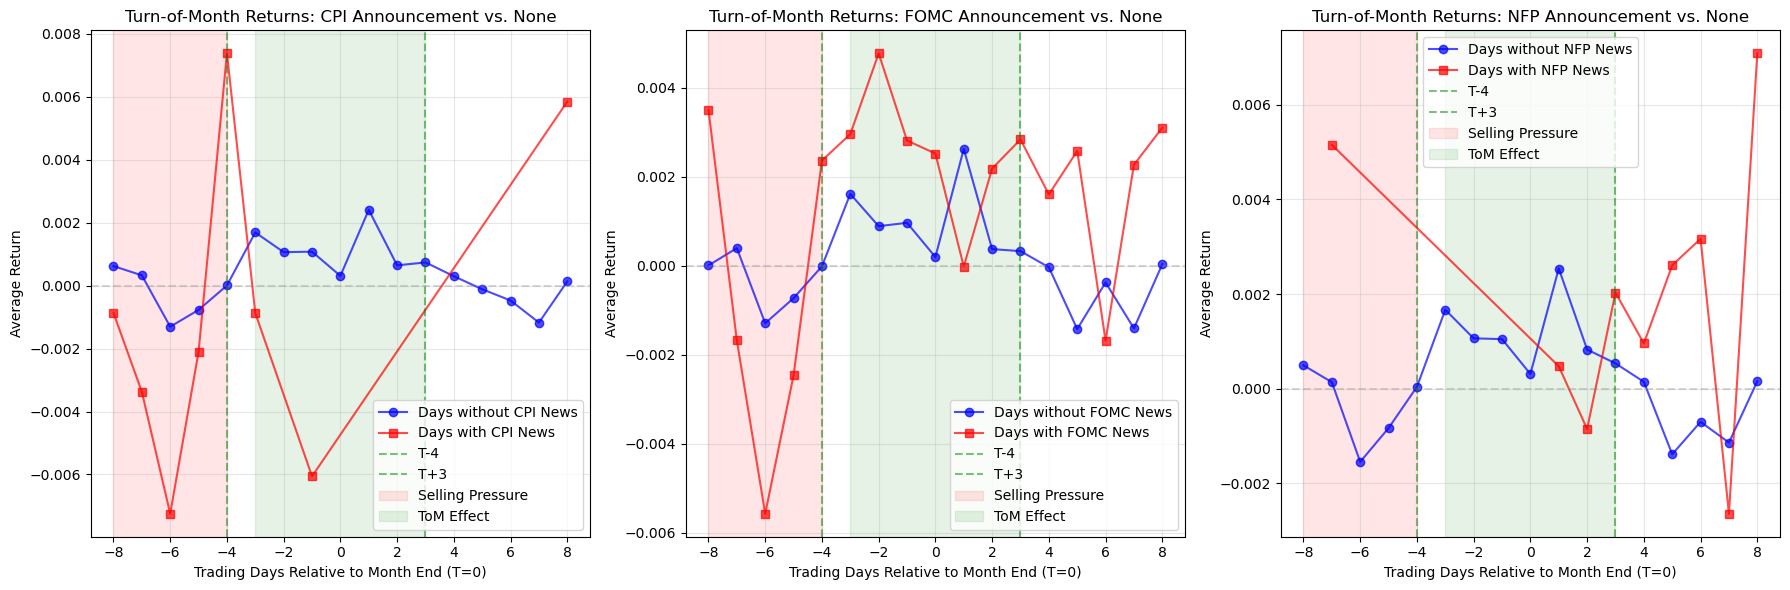

In [82]:
plot_macro_by_type(merged_data)